## 1. Vehicle Routing Problem

In [30]:
import numpy as np
from Numberjack import *
import matplotlib.pyplot as plt
import networkx as ntx
import random


a) Criação de uma rede de estradas (ou seja um grafo orinetado e pesado) com caminhos aleatórios e atribuição de valores às variaveis:

    i)Node: podem ser considerados "cidades" pois se pode (ou nao) encontrar os clientes
    ii)Carros: número de carros que a empresa tem disponiveis
    iii)NumClientes: Numero máximo de Clientes

É feita a atribuição de um "tempo" aleatório a cada aresta com um valor entre (1,10)  

Qualquer uma destas variáveis pode ser alterada sem correr o risco de estragar o programa desde que esta alteração seja feita com bom senso (por exemplo nao ter mais nodos que clientes ou ter qualquer um deles negativo).

Também é possivel alterar a frequência de ligações e para este teste consideramos (4,0.5) a melhor combinação

Mapa da cidade


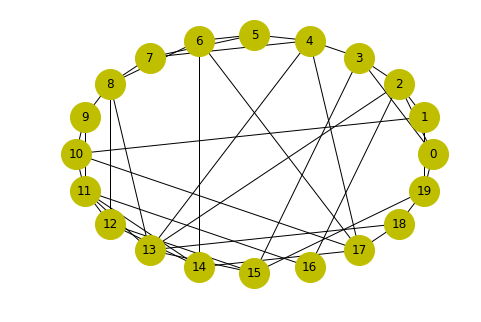

In [31]:
#Atribuições
Nodes = 20
Carros = 3
NumClientes = 15

g = ntx.DiGraph()
g = ntx.connected_watts_strogatz_graph(Nodes,4,0.5)

for i, j in g.edges():
    r = np.random.randint(1,10)
    g.add_edge(i,j,weight = r)
    g.add_edge(j,i,weight = r)

print("Mapa da cidade")
ntx.draw_shell(g,arrows=False,node_size=900,node_color='y',with_labels=True)
plt.show()

b)  $C_{i,j}$ e $t_{i,j}$ 

Assumimos o Nodo 0 como sendo a "central" da empresa de onde partem e retornam todos os veículos.

Criação de um grafo completo apartir do grafo anterior em que cada aresta é o caminho mais curto entre cada nodo.

Gera-se também um array "Clientes" que contém os clientes a ser atendidos.

E finalmente retira-se do grafo anterior os nodos que não são clientes ou a central da empresa e as respetivas arestas.

Grafo completo


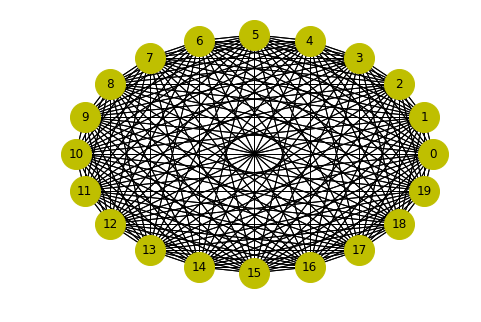

Grafo final


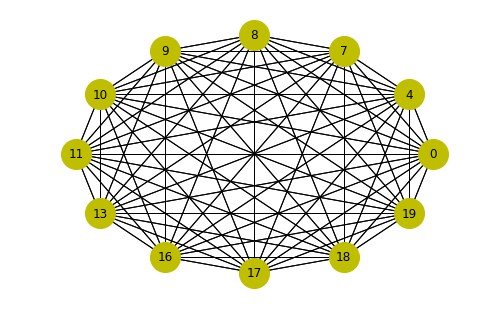

In [32]:
G = ntx.DiGraph()

G.add_nodes_from(g)
EdgesP = []

#inicializar a matriz
for i in range(Nodes):
    EdgesP.append([])
    for j in range(Nodes):
        EdgesP[i].append(-1)
        
#colocar os pesos ja calculados
for i, j, p in g.edges(data = True):
    w = p['weight']
    EdgesP[j][i] = EdgesP[i][j] = w
    G.add_edge(i, j, weight = w)
    G.add_edge(j, i, weight = w)

#calcular os caminhos mais curtos
dic = ntx.shortest_path(G, weight = 'weight')

#colocar os menores pesos
for i in range(Nodes):
    for j in range(Nodes):
        w = 0
        for k in range(len(dic[i][j])-1):
            i1 = dic[i][j][k]
            i2 = dic[i][j][k+1]
            w += EdgesP[i1][i2]
        EdgesP[i][j] = w
        G.add_edge(i,j,weight = w)
        
#criar clientes
Clientes = np.unique(np.random.choice(range(1,Nodes), NumClientes))
NumClientes = len(Clientes)

#for i in EdgesP:
#    print(i)

#Grafo completo
print("Grafo completo")
ntx.draw_shell(G,arrows=False,node_size=900,node_color='y',with_labels=True)
plt.show()

G_clientes = G.copy()

for i in range(Nodes):
    if(i not in Clientes and i != 0 ):
        G_clientes.remove_node(i)

#Grafo final
print("Grafo final")
ntx.draw_shell(G_clientes,arrows=False,node_size=900,node_color='y',with_labels=True)
plt.show()

### Restrições

Para a resolução deste problema criamos uma matriz binária de carros por arestas em que:

    0)Significa que o carro não utiliza aquela aresta (rua)
    1)Significa que o carro utiliza aquela aresta (rua)

Obrigar a ir apenas aos clientes: 

$\forall_{c\leq Carros}\forall_{i\leq Nodes}\big(i \in Clintes \land i \neq 0 \Rightarrow \sum_{j\leq Nodes} Mat[c][i*Nodes+j]+Mat[c][j*Nodes+i]= 0 \big)$

Obrigar a que as arestas do tipo (i,i) tenham peso 0 :

$\forall_{c\leq Carros}\forall_{n\leq Nodes}\big(Mat[c][n*Nodes+n]= 0 \big)$

Obrigar os clientes a serem atendidos uma unica vez:

$\forall_{c\leq Clientes}\big(\sum_{i\leq Carros, j\leq Nodos}Mat[i][c*Nodes+j]= 1 \big)$
$\forall_{c\leq Clientes}\big(\sum_{i\leq Carros, j\leq Nodos}Mat[i][j*Nodes+c]= 1 \big)$

Obrigar a começar e acabar no 0:


$\forall_{c\leq Carros}\big(\sum_{i\leq Nodos}Mat[c][0*Nodes+i]= 1 \big)$       
$\forall_{c\leq Carros}\big(\sum_{i\leq Nodos}Mat[c][i*Nodes+0]= 1 \big)$

Minimizar o custo (tempo):

$\forall_{c\leq Carros}minimize\big(\sum_{i\leq Nodes,j\leq Nodes}EdgesP[i][j]*Mat[c][i*Nodes + j]\big)$

Minimizar os carros:

$minimize\big(\sum_{c\leq Carros}\big(\sum_{e\leq Nodes²}Mat[c][e]\big)>0\big)$

Verificar que o caminho faz sentido:

$\forall_{c\leq Carros}\forall_{i\leq Clientes}\big(\sum_{j\leq Nodes}Mat[c][i*Nodes+j]-Mat[c][j*Nodes+i]=0\big)$

In [33]:
Mat = Matrix(Carros,Nodes**2)
model = Model()

#obrigar a ir apenas aos clientes

for c in range(Carros):
    for i in range(Nodes):
        if(i not in Clientes and i != 0):
            model.add( Sum([ Mat[c][i*Nodes+j]+Mat[c][j*Nodes+i] for j in range(Nodes)]) == 0 )

#Obrigar a que as arestas do tipo (i,i) sejam 0

for c in range(Carros):
    for n in range(Nodes):
        model.add(Mat[c][n*Nodes+n]==0)
        
#Obrigar os clientes a serem atendidos uma unica vez

for c in Clientes.tolist():
    A = [ Mat[i][c*Nodes+j] for i in range(Carros) for j in range(Nodes) ]
    B = [ Mat[i][j*Nodes+c] for i in range(Carros) for j in range(Nodes) ]
    model.add( Sum(A) == 1 )
    model.add( Sum(B) == 1 )

#Obrigar a começar e acabar no 0

for c in range(Carros):
    # p = 1 se o carro esta, p = 0 se o carro nao esta
    p = (Sum([ Mat[c][e] for e in range(Nodes**2)]) > 0)
    model.add( Sum([ Mat[c][0*Nodes + i] for i in range(Nodes)]) == p )
    model.add( Sum([ Mat[c][i*Nodes + 0] for i in range(Nodes)]) == p )
               
#Minimizar o custo

for c in range(Carros):
    model += Minimise(Sum([ EdgesP[i][j]*Mat[c][i*Nodes + j] for i in range(Nodes)\
                                                             for j in range(Nodes)]))

#Minimizar os carros

model += Minimise(Sum([ (Sum([ Mat[c][e] for e in range(Nodes**2)]) > 0) for c in range(Carros)]))

#Verificar que o caminho faz sentido

for c in range(Carros):
    for i in range(Nodes):  
        model.add( Sum([ Mat[c][i*Nodes+j]-Mat[c][j*Nodes+i] for j in range(Nodes)]) == 0 )
        
    #obrigar a que nao haja ciclos distintos
    for i in range(Nodes):
        for j in range(Nodes):
            model.add(  )
    

print()
#print(model)
model.load('SCIP').solve()

True

### Resultado Final

Lista de Clientes
[ 4  7  8  9 10 11 13 16 17 18 19]

Carro 1


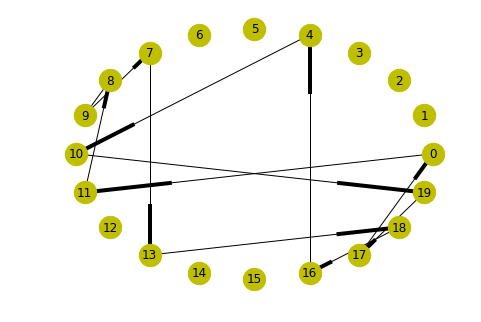


Carro 2


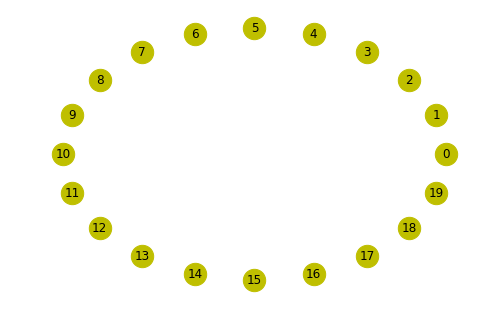


Carro 3


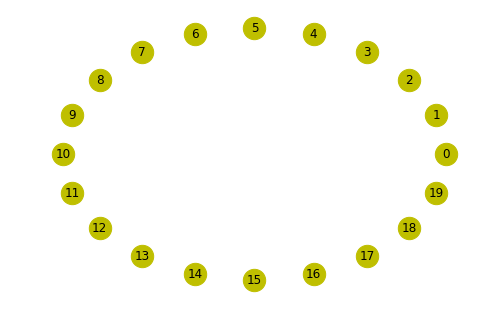

In [34]:
#print(Mat)
print("Lista de Clientes")
print(Clientes)

for c in range(Carros):
    print("\nCarro",c+1)
    
    Gaux = ntx.DiGraph()

    Gaux.add_nodes_from(g)

    for i in range(Nodes):
        for j in range(Nodes):
            if(Mat[Carros-c-1][i*Nodes+j].get_value()==1):
                Gaux.add_edge(i,j)

    ntx.draw_shell(Gaux,arrows=True,node_size=500,node_color='y',with_labels=True)
    plt.show()

## 2. Sudoku

### Criação do sudoku

In [27]:
N = 3
NS = N*N
Gre = Matrix(NS,NS,1,NS)
model = Model()


## Popular a Grelha de Sudoku




### Restrições
Preencher a Grelha
todos os pequenos quadrados têm diferentes números

$\forall_{i< N²}\forall_{j< N²}\forall_{i<i2\leq N²}
\forall_{j<j2\leq N²}\big(M[i,j] =M[i2,j2] \Rightarrow \big(i/N \neq i2/N\big) \vee \big(j/N \neq j2/N\big)  \big)$
        
todas as linhas têm diferentes números

$\forall_{i\leq N²}\forall_{j< N²}\forall_{j<j2\leq N²}\big(M[i,j] \neq M[i,j2] \big)$

todas as colunas têm diferentes números

$\forall_{i< N²}\forall_{i<i2\leq N²}\forall_{j\leq N²}\big(M[i,j] \neq M[i2,j] \big)$


In [28]:
for i in range(N):
    for j in range(N):
        model.add(AllDiff(Gre[i*N:(i+1)*N,j*N:(j+1)*N].flat))
        model.add(AllDiff(Gre[i*N+j]))
        model.add(AllDiff(Gre.col[i*N+j]))



### Resolução

In [29]:
model.load('SCIP').solve()

print(Gre)

[[8, 3, 5, 9, 1, 6, 7, 4, 2],
 [7, 6, 9, 4, 5, 2, 3, 1, 8],
 [1, 2, 4, 7, 3, 8, 5, 6, 9],
 [9, 5, 6, 2, 8, 1, 4, 3, 7],
 [3, 8, 7, 6, 9, 4, 1, 2, 5],
 [4, 1, 2, 5, 7, 3, 9, 8, 6],
 [6, 7, 3, 1, 2, 9, 8, 5, 4],
 [2, 9, 1, 8, 4, 5, 6, 7, 3],
 [5, 4, 8, 3, 6, 7, 2, 9, 1]]
